# Overview

Hurricane Ian was a Category 5 Atlantic hurricane, between Sep 21, 2022 and Oct 1, 2022.

In [1]:
import os
import sys
import time
import warnings
from copy import deepcopy
from datetime import datetime, timedelta
from pathlib import Path 

import geopandas as gpd
import matplotlib.pyplot as plt
#import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import xarray as xr
from cartopy.feature import NaturalEarthFeature
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, LogNorm
from matplotlib.dates import DateFormatter
from pyproj import CRS
from shapely.geometry import Polygon, box, MultiPolygon
from shapely.ops import polygonize

from pyschism.mesh import Hgrid
from searvey.coops import coops_product_within_region, coops_stations_within_region
from stormevents import StormEvent

In [2]:
PathToMyFunctions = Path('.').absolute() / 'utility'

sys.path.append(str(PathToMyFunctions))

from SchismFunctions import read_SchismWaterElevation2D
from SchismFunctions import read_ObservedWaterLevel
from PythonFunctions import find_indices2D

In [3]:
warnings.filterwarnings("ignore")  # turn off warnings

In [4]:
def plot_multiple_TimeSeries_comparison(data, data2, data_observed=None, **kwargs):
    rounding_base = kwargs.get('rounding_base', None)
    station_label = kwargs.get('station_label', None)
    DPI = kwargs.get('DPI', None)
    save_file_name = kwargs.get('save_file_name', None)
    yd = kwargs.get('yd', None)
    yu = kwargs.get('yu', None)
    date_rng = kwargs.get('date_rng', None) # in datetime format (datetime(yyyy, mm, dd))

    base=1 if (rounding_base is None) else rounding_base
    
    # Figure dpi resolution:
    if DPI is None:       DPI = 120
    
    if station_label is None:
        station_label = ['NOS Station: '+str(x+1) for x in range(Nplots)]
    
    Nplots = data.shape[1]  # number of subplots (=number of selcted stations)
    if Nplots <=6:
        row, col = Nplots, 1 # number of rows and columns
        figW, figH = 6.5, min(8.0, row*2.0)  # Figure width and height
        figWspace, figHsapce = 0.00, 0.075
    else:
        row, col = int(np.ceil(Nplots/2)) , 2 # number of rows and columns
        figW, figH = 6.5, min(8.0, row*2.0)  # Figure width and height
        figWspace, figHsapce = 0.15, 0.10
        
    fig, axs = plt.subplots(row , col, figsize=(figW, figH), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = figHsapce, wspace=figWspace)
    
    axs = axs.ravel()
    for i in range(Nplots):
        axs[i].plot(data.iloc[:,i], linewidth=0.5, label='PaHm')  # predicted
        if data2 is not None:
            axs[i].plot(data2.iloc[:,i], linewidth=0.5, label='ERA5')  # predicted 2nd case
        
        if data_observed is not None:
            axs[i].plot(data_observed.iloc[:,i], linewidth=0.5, label='obs')  # observed

        axs[i].grid(axis = 'both', color = 'gray', linestyle = '-', linewidth = 0.75, alpha=0.15)
        axs[i].tick_params(axis="both",direction="in")  #, pad=0
        plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=90)
        
        # beautify the x-labels
        plt.gcf().autofmt_xdate()
        # Define the date format
        date_form = DateFormatter("%b-%d")
        axs[i].xaxis.set_major_formatter(date_form)        
        axs[Nplots-2].tick_params(axis='x', rotation=90)
        axs[Nplots-1].tick_params(axis='x', rotation=90)        
        plt.setp(axs[Nplots-2].xaxis.get_majorticklabels(), ha='left')
        plt.setp(axs[Nplots-1].xaxis.get_majorticklabels(), ha='left')
         
        if date_rng is not None:
            plt.setp(axs[i], xticks=date_rng)
            axs[i].set_xlim([date_rng[0], date_rng[-1]])
        
        yd=base * np.floor(min(data.iloc[:,i])/base) if (yd is None) else yd
        yu=base *  np.ceil(max(data.iloc[:,i])/base) if (yu is None) else yu
#        axs[i].set_ylim([yd,yu])
        axs[i].set_ylim([-2.5,2.5])
    
    
        axs[i].text(0.5, 0.975, station_label[i],
                 horizontalalignment='center', verticalalignment='top',
                 transform=axs[i].transAxes, size=9,weight='bold')
    # add legend:
    axs[Nplots-1].legend(loc="lower right", ncol=3)
    
    fig.add_subplot(111, frame_on=False)
    plt.tick_params(labelcolor="none", bottom=False, left=False)
    #plt.xlabel("Date")
    plt.ylabel('WSE (m)', size=11,weight='bold')

Get the best track data of Hurricane Ian, and write it into file (hurricane-track.dat)

In [5]:
obs_bbox = -99.0, 5, -52.8, 46.3

# Observation times
obs_year = 2022
obs_months = [8, 9, 10, 11]

workdir = Path('.')

PathToObsrv = workdir / 'coops_water_level_observations' / f'water_levels_atlantic_{obs_year}_months_{obs_months[0]}_{obs_months[-1]}.nc'
PathToHgrid = workdir / 'mesh'/ 'mesh_w_bdry.gr3'

Path_pahmc = workdir / 'pahmc/outputs'
Path_era5c = workdir / 'era5nc/outputs'
Path_tide = workdir / 'new41/outputs'

In [6]:
storm = StormEvent('ian', 2022)
storm_best_track = storm.track()
storm_advisory_track = storm.track(advisories=['OFCL'])

In [7]:
gdf_countries = gpd.GeoSeries(NaturalEarthFeature(category='physical', scale='10m', name='land').geometries(), crs=4326)

In [8]:
water_levels_within_34kt = storm.coops_product_within_isotach('hourly_height', wind_speed=34)
water_levels_within_50kt = storm.coops_product_within_isotach('hourly_height', wind_speed=50)
water_levels_within_34kt

<xarray.Dataset>
Dimensions:  (t: 241, nos_id: 33)
Coordinates:
  * t        (t) datetime64[ns] 2022-09-21T06:00:00 ... 2022-10-01T06:00:00
  * nos_id   (nos_id) object '8720030' '8726384' ... '8661070' '8656483'
    nws_id   (nos_id) <U5 'FRDF1' 'PMAF1' 'FMRF1' ... 'JMPN7' 'MROS1' 'BFTN7'
    x        (nos_id) float64 -81.47 -82.56 -81.87 ... -77.79 -78.92 -76.67
    y        (nos_id) float64 30.67 27.64 26.65 26.08 ... 34.21 33.66 34.72
Data variables:
    v        (nos_id, t) float32 1.568 1.814 2.081 2.281 ... 2.021 1.906 1.755
    s        (nos_id, t) float32 0.008 0.008 0.006 0.004 ... 0.02 0.015 0.017
    f        (nos_id, t) object '0,0' '0,0' '0,0' '0,0' ... '0,0' '0,0' '0,0'
    q        (nos_id, t) object <NA> <NA> <NA> <NA> <NA> ... <NA> <NA> <NA> <NA>

Plot the best track and 34/50/64kt wind swath around best track

Text(0.5, 1.0, 'IAN 2022 CO-OPS maximum water levels')

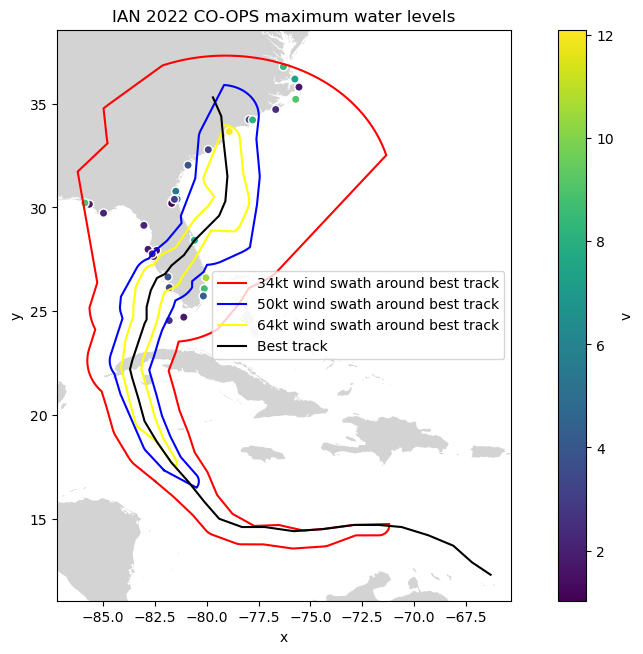

In [9]:
figure, axis = plt.subplots(1, 1)
figure.set_size_inches(12, 12 / 1.61803398875)

axis.plot(*storm_best_track.wind_swaths(wind_speed=34)['BEST']['20220922T180000'].exterior.xy, c='red',
          label='34kt wind swath around best track')

axis.plot(*storm_best_track.wind_swaths(wind_speed=50)['BEST']['20220922T180000'].exterior.xy, c='blue',
          label='50kt wind swath around best track')

axis.plot(*storm_best_track.wind_swaths(wind_speed=64)['BEST']['20220922T180000'].exterior.xy, c='yellow',
          label='64kt wind swath around best track')

axis.plot(*storm_best_track.linestrings['BEST']['20220922T180000'].xy, c='black',label='Best track')

water_levels_within_34kt.max('t').plot.scatter(x='x', y='y', hue='v', cmap='viridis', ax=axis)

xlim = axis.get_xlim()
ylim = axis.get_ylim()
gdf_countries.plot(color='lightgrey', ax=axis, zorder=-1)
axis.set_xlim(xlim)
axis.set_ylim(ylim)

axis.legend()
axis.set_title(f'{storm.name} {storm.year} CO-OPS maximum water levels')

# Validation

In [10]:
datasets = []

# COOPS 6-minute data can be fetched for 1 month at a time.
for i in obs_months:
    t0 = datetime(obs_year, i, 1, 0, 0, 0)
    tend = datetime(obs_year, i+1, 1, 0, 0, 0)
    
    water_levels = coops_product_within_region(
        product='water_level',
        start_date=t0.isoformat(),
        end_date=tend.isoformat(),
        region=box(*obs_bbox)
    )
    
    datasets.append(water_levels)

combined_water_levels = xr.concat(datasets, dim='t') 
PathToObsrv.parent.mkdir(exist_ok=True, parents=True)
combined_water_levels.to_netcdf(PathToObsrv)

Text(0.5, 1.0, 'IAN 2022 CO-OPS maximum water levels')

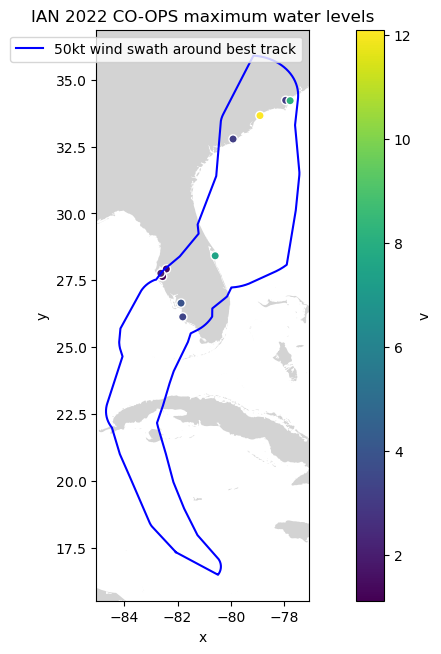

In [11]:
figure, axis = plt.subplots(1, 1)
figure.set_size_inches(12, 12 / 1.61803398875)

axis.plot(*storm_best_track.wind_swaths(wind_speed=50)['BEST']['20220922T180000'].exterior.xy, c='blue',
          label='50kt wind swath around best track')

water_levels_within_50kt.max('t').plot.scatter(x='x', y='y', hue='v', cmap='viridis', ax=axis)

xlim = axis.get_xlim()
ylim = axis.get_ylim()
gdf_countries.plot(color='lightgrey', ax=axis, zorder=-1)
axis.set_xlim(xlim)
axis.set_ylim(ylim)

axis.legend()
axis.set_title(f'{storm.name} {storm.year} CO-OPS maximum water levels')

# Find observations in the storm_best_track.wind_swaths

Get CO-OPS data:

In [12]:
ian_domain50 = MultiPolygon(list(polygonize(storm_best_track.wind_swaths(wind_speed=50)['BEST']['20220922T180000'].exterior)))
ian50_obs = coops_product_within_region('water_level', region=ian_domain50, start_date=datetime(2022, 9, 15), end_date=datetime(2022, 10, 15))
ian50_md = coops_stations_within_region(region=ian_domain50)
ian50_coops_id = ian50_obs['nos_id'].values

ian50_obs.nos_id

<xarray.DataArray 'nos_id' (nos_id: 10)>
array(['8726384', '8725520', '8721604', '8658120', '8725110', '8726674',
       '8665530', '8726520', '8658163', '8661070'], dtype=object)
Coordinates:
  * nos_id   (nos_id) object '8726384' '8725520' ... '8658163' '8661070'
    nws_id   (nos_id) <U5 'PMAF1' 'FMRF1' 'TRDF1' ... 'SAPF1' 'JMPN7' 'MROS1'
    x        (nos_id) float64 -82.56 -81.87 -80.59 ... -82.63 -77.79 -78.92
    y        (nos_id) float64 27.64 26.65 28.42 34.23 ... 27.76 34.21 33.66

Text(0.5, 1.0, 'maximum water levels observed by CO-OPS stations on the path of Hurriance Ian between 2022-09-15 00:00:00 and 2022-10-15 00:00:00')

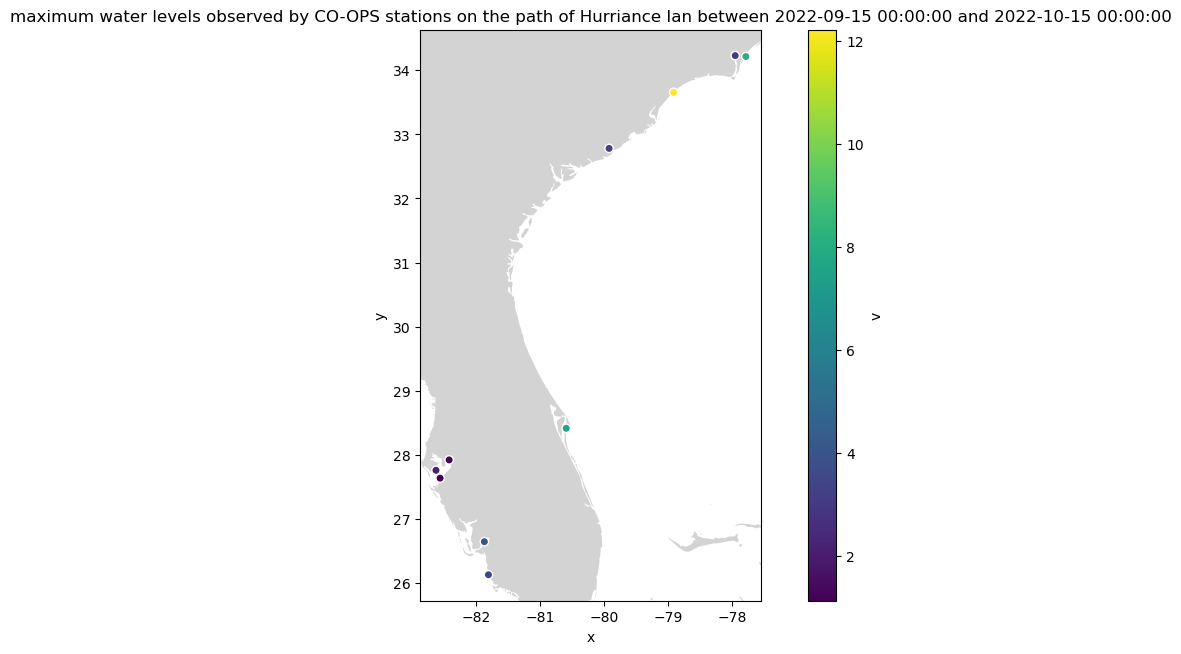

In [13]:
water_levels = ian50_obs
figure, axis = plt.subplots(1, 1)
figure.set_size_inches(12, 12 / 1.61803398875)

water_levels.max('t').plot.scatter(x='x', y='y', hue='v', cmap='viridis', ax=axis)

xlim = axis.get_xlim()
ylim = axis.get_ylim()
gdf_countries.plot(color='lightgrey', ax=axis, zorder=-1)
axis.set_xlim(xlim)
axis.set_ylim(ylim)

start_date = pd.to_datetime(water_levels['t'].min().values)
end_date = pd.to_datetime(water_levels['t'].max().values)
axis.set_title(f'maximum water levels observed by CO-OPS stations on the path of Hurriance Ian between {start_date} and {end_date}')

In [14]:
select_stations = ian50_coops_id[0:10]
hgrid = Hgrid.open(PathToHgrid, crs='EPSG:4326')

# Make adjustments to the observed sea level

In [15]:
ajustments = np.zeros(np.size(select_stations))
df_obs, data_obs, data_obs_selected, NOSstationIDs = read_ObservedWaterLevel(
    PathToObsrv, stations=select_stations, obs_adjustment=ajustments
)
ajustments = -np.mean(df_obs,axis=0)
print(ajustments)

  → Station list is defined, validation is performed at selected stations:
    Total number of selected stations: 10
8726384   -0.657658
8725520   -1.780959
8721604   -6.334061
8658120   -1.673772
8725110   -1.420418
8726674   -0.723219
8665530   -2.013044
8726520   -1.615919
8658163   -6.651704
8661070   -9.970024
dtype: float32


In [16]:
df_obs, data_obs, data_obs_selected, NOSstationIDs = read_ObservedWaterLevel(
    PathToObsrv,
    stations=select_stations,
    obs_adjustment=ajustments,
)
np.mean(df_obs,axis=0)

  → Station list is defined, validation is performed at selected stations:
    Total number of selected stations: 10


8726384   -3.491117e-08
8725520   -4.064286e-08
8721604   -3.631804e-07
8658120   -1.042125e-07
8725110   -1.732354e-08
8726674   -2.084249e-09
8665530    7.034341e-08
8726520    1.401658e-07
8658163    2.657418e-07
8661070    3.392116e-07
dtype: float32

In [17]:
data_obs_selected

<xarray.Dataset>
Dimensions:  (nos_id: 10, t: 29284)
Coordinates:
  * nos_id   (nos_id) object '8726384' '8725520' ... '8658163' '8661070'
  * t        (t) datetime64[ns] 2022-08-01 2022-08-01T00:06:00 ... 2022-12-01
    nws_id   (t, nos_id) object ...
    x        (t, nos_id) float64 ...
    y        (t, nos_id) float64 ...
Data variables:
    v        (nos_id, t) float32 0.577 0.566 0.555 0.544 ... 9.028 9.008 8.969
    s        (nos_id, t) float32 ...
    f        (nos_id, t) object ...
    q        (nos_id, t) object ...

In [18]:
pointsx = (data_obs_selected.x[-1].values) # for 2011 observed data use: data_obs_selected.y[-1].values
pointsy = data_obs_selected.y[-1].values # for 2011 observed data use: data_obs_selected.x[-1].values

pointsx[4] = -81-48.5/60.0 #https://tidesandcurrents.noaa.gov/stationhome.html?id=8725110
pointsy[4] = 26+7.9/60.0

print(pointsx)
print(pointsy)

points = np.column_stack([pointsx, pointsy])

print(np.size(points))

[-82.5625     -81.87110901 -80.5931015  -77.95361328 -81.80833333
 -82.42140198 -79.92360687 -82.62693787 -77.78668976 -78.91638947]
[27.63833046 26.64777946 28.41580009 34.22750092 26.13166667 27.92309952
 32.78083038 27.76111031 34.21331024 33.65555954]
20


In [19]:
points_indices = find_indices2D(points, hgrid.x, hgrid.y) # Indices for slected stations at the base run
print(points_indices)

[array([160626]), array([203583]), array([454519]), array([652485]), array([210493]), array([171580]), array([562959]), array([154539]), array([665063]), array([618328])]


In [20]:
df_sim_prior_t, times_t, t0_t, dt_t = read_SchismWaterElevation2D(
    str(Path_tide) + '/', points_indices, stationIDs=select_stations, old_version=None)  

df_sim_prior_pc, times_p, t0_p, dt_p = read_SchismWaterElevation2D(
    str(Path_pahmc) + '/', points_indices, stationIDs=select_stations, old_version=None)   

df_sim_prior_ec, times_e, t0_e, dt_e = read_SchismWaterElevation2D(
    str(Path_era5c) + '/', points_indices, stationIDs=select_stations, old_version=None) 

  → Reading the out2d_*.nc file for elevation ...
  → Station IDs are defined, data points are named based on NOS Station ID!
  → Reading the out2d_*.nc file for elevation ...
  → Station IDs are defined, data points are named based on NOS Station ID!
  → Reading the out2d_*.nc file for elevation ...
  → Station IDs are defined, data points are named based on NOS Station ID!


In [21]:
p1 = np.amax(df_sim_prior_pc,axis=0)
e1 = np.amax(df_sim_prior_ec,axis=0)

Text(0.5, 1.0, 'IAN 2022 height above ground')

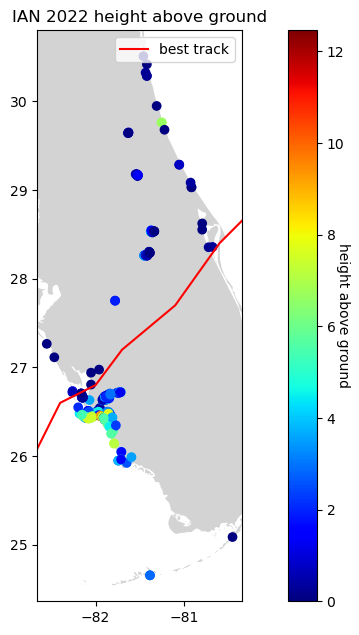

In [22]:
hwm = storm.flood_event.high_water_marks()
figure, axis = plt.subplots(1, 1)
figure.set_size_inches(12, 12 / 1.61803398875)

hwm.plot('height_above_gnd', ax=axis, cmap='jet')
colorbar = plt.colorbar(
    ScalarMappable(
        norm=Normalize(
            vmin=hwm['height_above_gnd'].min(),
            vmax=hwm['height_above_gnd'].max(),
        ),
        cmap='jet'
    ),
)
colorbar.set_label('height above ground', rotation=270)

xlim = axis.get_xlim()
ylim = axis.get_ylim()
axis.plot(*storm_best_track.linestrings['BEST']['20220922T180000'].xy, c='red', label='best track')
gdf_countries.plot(color='lightgrey', ax=axis, zorder=-1)
axis.set_xlim(xlim)
axis.set_ylim(ylim)

axis.legend()
axis.set_title(f'{storm.name} {storm.year} height above ground')

# Sea level time series comparisons

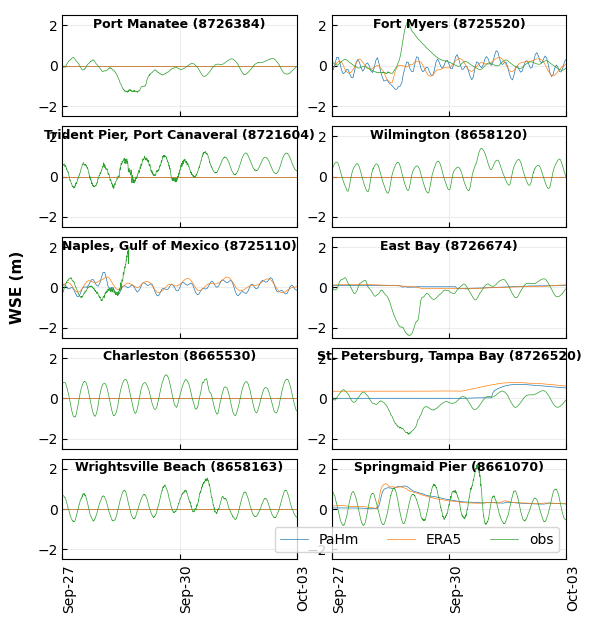

In [23]:
t0, te = datetime(2022, 9, 27), datetime(2022, 10, 2)

dt = timedelta(days=3) 
date_rng = np.arange(t0, te+dt, dt)

station_label = ian50_md.loc[select_stations.astype(int)].name.values

plot_multiple_TimeSeries_comparison(
    data=df_sim_prior_pc,
    data2=df_sim_prior_ec,
    data_observed=df_obs,
    date_rng=date_rng,
    station_label=[f'{n} ({i})' for n, i in zip(station_label, select_stations)]
)